# Performing a Optimized DenseNet based Classification for Blackgram plant leaf disease

# Import the necessary libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf

In [2]:
batch_size = 32
image_size = (224, 224)
epochs = 10

# Load the images and plot it

In [3]:
dataset_dir = 'E:\BPLD Dataset'

In [4]:
classes = os.listdir(dataset_dir)

In [5]:
data = []
for class_name in classes:
    class_path = os.path.join(dataset_dir, class_name)
    images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
    labels = [class_name] * len(images)
    data.extend(list(zip(images, labels)))

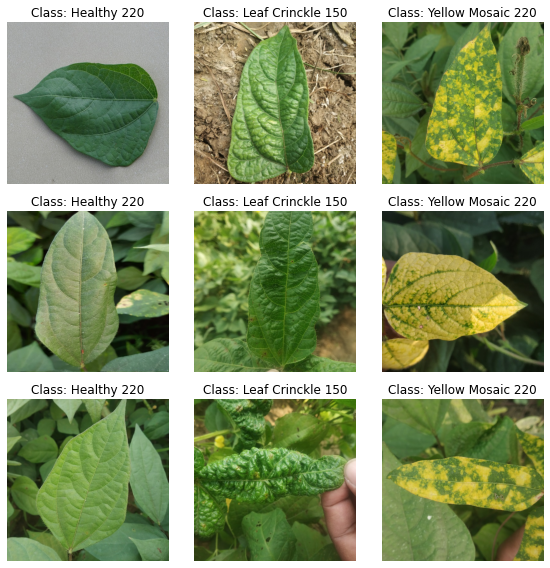

In [6]:
sample_size = 3
classes_to_display = random.sample(classes, sample_size)
fig, axes = plt.subplots(sample_size, len(classes_to_display), figsize=(8, 8))

for i, class_name in enumerate(classes_to_display):
    class_path = os.path.join(dataset_dir, class_name)
    class_images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
    for j in range(sample_size):
        random_image_path = random.choice(class_images)
        img = mpimg.imread(random_image_path)

        axes[j, i].imshow(img)
        axes[j, i].set_title(f'Class: {class_name}')
        axes[j, i].axis('off')
plt.tight_layout()
plt.show()

# Split the data into 80% and 20%

In [7]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Augment the training images

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Setting up Data Generators for Training and Testing

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame(train_data, columns=['Image', 'Label']),
    x_col='Image',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame(test_data, columns=['Image', 'Label']),
    x_col='Image',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 805 validated image filenames belonging to 5 classes.
Found 202 validated image filenames belonging to 5 classes.


# Building the model(DenseNet121)

In [10]:
base_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classes), activation='softmax'))

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0:
        return lr * 0.9
    else:
        return lr
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Training the model

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[lr_callback]
)

Epoch 1/10
25/25 [==============================] - 95s 3s/step - loss: 1.1309 - accuracy: 0.5757 - val_loss: 0.5712 - val_accuracy: 0.8542 - lr: 9.0000e-04
Epoch 2/10
25/25 [==============================] - 83s 3s/step - loss: 0.5129 - accuracy: 0.8137 - val_loss: 0.4370 - val_accuracy: 0.8385 - lr: 9.0000e-04
Epoch 3/10
25/25 [==============================] - 83s 3s/step - loss: 0.3685 - accuracy: 0.8862 - val_loss: 0.2827 - val_accuracy: 0.9219 - lr: 9.0000e-04
Epoch 4/10
25/25 [==============================] - 84s 3s/step - loss: 0.2755 - accuracy: 0.9120 - val_loss: 0.2440 - val_accuracy: 0.8958 - lr: 9.0000e-04
Epoch 5/10
25/25 [==============================] - 83s 3s/step - loss: 0.2451 - accuracy: 0.9237 - val_loss: 0.2183 - val_accuracy: 0.9427 - lr: 9.0000e-04
Epoch 6/10
25/25 [==============================] - 82s 3s/step - loss: 0.2050 - accuracy: 0.9353 - val_loss: 0.2090 - val_accuracy: 0.9115 - lr: 8.1000e-04
Epoch 7/10
25/25 [==============================] - 87s 3s

# Prediction on test data

In [14]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy * 100:.2f}%')

7/7 [==============================] - 17s 2s/step - loss: 0.1710 - accuracy: 0.9257
Test accuracy: 92.57%


# Plotting the Accuracy and Loss

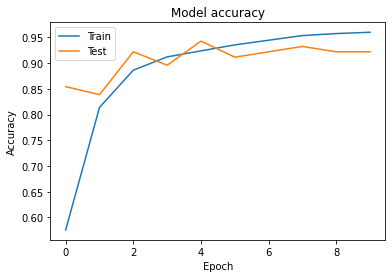

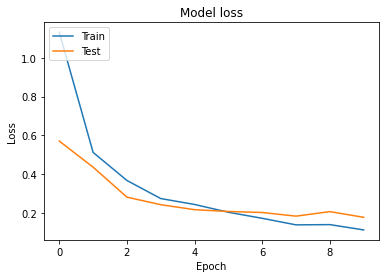

In [15]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_history(history)

# Visualizing Predictions on Random images

In [17]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img, img_array

1/1 [==============================] - 0s 161ms/step


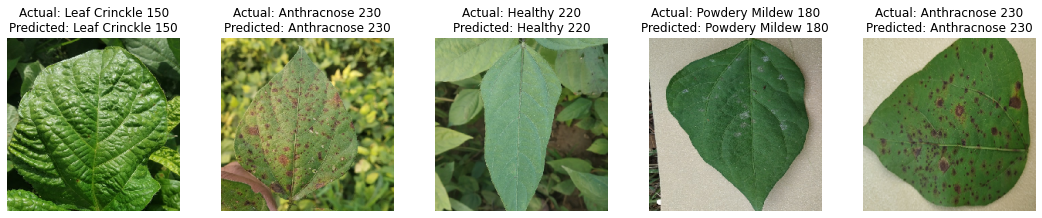

In [18]:
random_indices = np.random.choice(test_generator.samples, size=5, replace=False)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, idx in enumerate(random_indices):
    img_path = test_generator.filepaths[idx]
    true_label = test_generator.classes[idx]

    # Load and preprocess the image
    img, img_array = load_and_preprocess_image(img_path)

    # Make predictions
    predictions = model.predict(img_array)
    predicted_label = classes[np.argmax(predictions)]

    axes[i].imshow(img)
    axes[i].set_title(f'Actual: {classes[true_label]}\nPredicted: {predicted_label}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()
